<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-01-20 14:53:18--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2020-01-20 14:53:19 (304 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         156 KB  anaconda
    seaborn-0.9.0              |     pyh91ea838_1         164 KB  anaconda
    openssl-1.1.1              |       h7b6447c_0         5.0 MB  anaconda
    ca-certificates-2019.11.27 |                0         132 KB  anaconda
    ------------------------------------------------------------
                                           Total:         5.5 MB

The following packages will be UPDATED:

    ca-certificates: 2019.11.27-0       --> 2019.11.27-0       anaconda
    certifi:         2019.11.28-py36_0  --> 2019.11.28-py36_0  anaconda
    openssl:         1.1.1d-h7b6447c_3  --> 1.1.1-h7b6447c_0   anaconda
    seaborn:         0.9.0-py

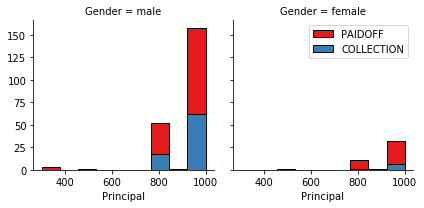

In [10]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

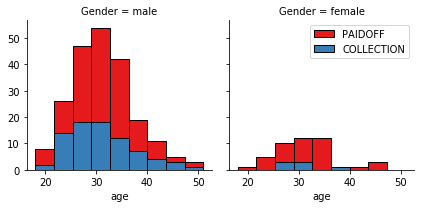

In [11]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

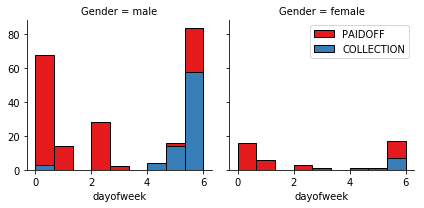

In [12]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [13]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [15]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [16]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [17]:
#Master or Above has strabge numbers, 50%-50%. I review this data
df[df.education=='Master or Above']

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
50,59,59,PAIDOFF,800,15,2016-09-11,2016-09-25,39,Master or Above,0,6,1
293,342,342,COLLECTION,1000,15,2016-09-11,2016-09-25,50,Master or Above,0,6,1


#### Feature befor One Hot Encoding

In [18]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [19]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [20]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [21]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [22]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [23]:
#Classification: K nearest neighbor (KNN)
from sklearn.neighbors import KNeighborsClassifier
k = 7
#Train Model and Predict  
kneigh = KNeighborsClassifier(n_neighbors = k).fit(X,y)

#Predicting
y_hat = kneigh.predict(X)

#Accuracy evaluation
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y, kneigh.predict(X)))

#f1_score
from sklearn.metrics import f1_score
print('KMM f1_score train: ', f1_score(y, y_hat, average='weighted'))

#jaccard index for accuracy:
from sklearn.metrics import jaccard_similarity_score
print('KMM jaccard score train: ', jaccard_similarity_score(y, y_hat))

Train set Accuracy:  0.8092485549132948
KMM f1_score train:  0.7955764876306204
KMM jaccard score train:  0.8092485549132948


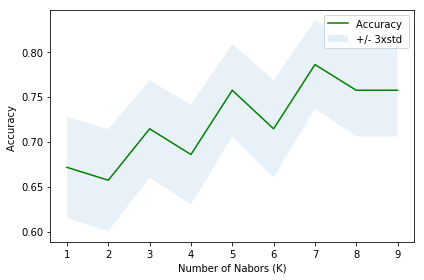

In [24]:
#We calculate the accuracy of KNN for different Ks to check which value of k is the best
#Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    #Train Model and Predict  
    kneigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    y_hat=kneigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_hat)
    std_acc[n-1]=np.std(y_hat==y_test)/np.sqrt(y_hat.shape[0])
mean_acc
std_acc

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [25]:
#I repeat the modeling by adjusting the k to 7
k = 7
#Train Model and Predict  
kneigh = KNeighborsClassifier(n_neighbors = k).fit(X,y)

#Predicting
y_hat = kneigh.predict(X)
y_hat[0:5]

#Accuracy evaluation
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y, kneigh.predict(X)))
#f1_score
from sklearn.metrics import f1_score
print('KMM f1_score train: ', f1_score(y, y_hat, average='weighted'))

#jaccard index for accuracy:
from sklearn.metrics import jaccard_similarity_score
print('KMM jaccard score train: ', jaccard_similarity_score(y, y_hat))

Train set Accuracy:  0.8092485549132948
KMM f1_score train:  0.7955764876306204
KMM jaccard score train:  0.8092485549132948


# Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#Modeling
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 7)
loanTree.fit(X,y)

#Prediction
predictionTree = loanTree.predict(X)

#Evaluation
from sklearn import metrics
print("DTree Accuracy train: ", metrics.accuracy_score(y, predictionTree))

#f1_score
from sklearn.metrics import f1_score
print('DTree f1_score train: ', f1_score(y, predictionTree, average='weighted'))

#jaccard index for accuracy:
from sklearn.metrics import jaccard_similarity_score
print('DTree jaccard score train: ', jaccard_similarity_score(y, predictionTree))

DTree Accuracy train:  0.8005780346820809
DTree f1_score train:  0.7881942828571212
DTree jaccard score train:  0.8005780346820809


I draw the decision tree

In [27]:
!pip install graphviz
!pip install pydotplus

     |████████████████████████████████| 286kB 7.9MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


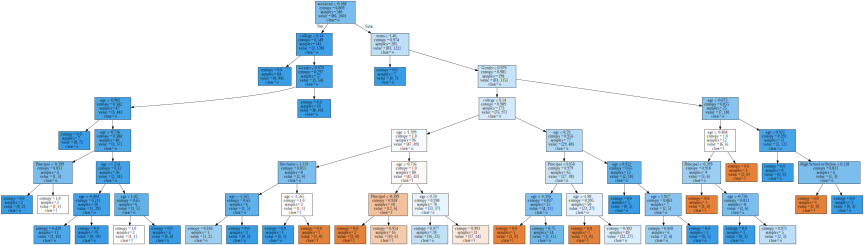

In [28]:
import pydotplus
import graphviz 

featureNames = Feature.columns
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=None, class_names= 'loan_status', filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(out)  
graph.set_size('"12!"')
gvz_graph = graphviz.Source(graph.to_string())
gvz_graph

# Support Vector Machine

In [29]:
#We test different values for kernel function, 'rbf', 'linear' and 'sigmoid'. We choose the one that gives us the best indicators
from sklearn import svm
clf_rbf = svm.SVC(kernel='rbf')
clf_rbf.fit(X, y) 
y_hat = clf_rbf.predict(X)

#f1_score
from sklearn.metrics import f1_score
print('SVM f1_score train: ', f1_score(y, y_hat, average='weighted'))

#jaccard index for accuracy:
from sklearn.metrics import jaccard_similarity_score
print('SVM jaccard score train: ', jaccard_similarity_score(y, y_hat))


SVM f1_score train:  0.6647688577527595
SVM jaccard score train:  0.7601156069364162


In [30]:
from sklearn import svm
clf_lin = svm.SVC(kernel='linear')
clf_lin.fit(X, y) 
y_hat = clf_lin.predict(X)

#f1_score
from sklearn.metrics import f1_score
print('SVM f1_score train: ', f1_score(y, y_hat, average='weighted'))

#jaccard index for accuracy:
from sklearn.metrics import jaccard_similarity_score
print('SVM jaccard score train: ', jaccard_similarity_score(y, y_hat))

SVM f1_score train:  0.6448043648295465
SVM jaccard score train:  0.7514450867052023


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
from sklearn import svm
clf_sig = svm.SVC(kernel='sigmoid')
clf_sig.fit(X, y) 
y_hat = clf_sig.predict(X)

#f1_score
from sklearn.metrics import f1_score
print('SVM f1_score train: ', f1_score(y, y_hat, average='weighted'))

#jaccard index for accuracy:
from sklearn.metrics import jaccard_similarity_score
print('SVM jaccard score train: ', jaccard_similarity_score(y, y_hat))

SVM f1_score train:  0.6320215591313857
SVM jaccard score train:  0.7167630057803468


We choose the 'rbf' option for the kernel function

# Logistic Regression

In [32]:
#Modeling (Logistic Regression with Scikit-learn)
from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression(C=0.001, solver='liblinear').fit(X,y)
y_hat = LogReg.predict(X)

#f1_score
from sklearn.metrics import f1_score
print('LogReg f1_score train: ', f1_score(y, y_hat, average='weighted'))

#jaccard index for accuracy:
from sklearn.metrics import jaccard_similarity_score
print('LogReg jaccard score train: ', jaccard_similarity_score(y, y_hat))

#log loss
from sklearn.metrics import log_loss
y_hat_prob = LinReg.predict_proba(X)
print('LogReg log_loss train: ', log_loss(y, y_hat_prob))

LogReg f1_score train:  0.7006869534979117
LogReg jaccard score train:  0.7514450867052023


NameError: name 'LinReg' is not defined

# Model Evaluation using Test set

In [33]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [34]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-01-20 15:00:17--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-01-20 15:00:17 (510 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [35]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [36]:
#First, we need to transform test data as we did with train data
test_df['effective_date']= pd.to_datetime(test_df['effective_date'])
test_df['due_date']= pd.to_datetime(test_df['due_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [37]:
X_test = Feature_test
X_test= preprocessing.StandardScaler().fit(X_test).transform(X_test)
y_test = test_df['loan_status'].values

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [38]:
#Predicting
y_hat_knn = kneigh.predict(X_test)
y_hat_tree = loanTree.predict(X_test)
y_hat_clf = clf_rbf.predict(X_test)
y_hat_logreg = LogReg.predict(X_test)

In [40]:
#Evaluation
#f1_score
df_eval = pd.DataFrame(index=['KNN', 'Decision Tree', 'SVM', 'Logistic Regression'], columns=['F1 score', 'Jaccard', 'Log loss'])
df_eval.iloc[0, 0] = f1_score(y_test, y_hat_knn, average='weighted')
df_eval.iloc[1, 0] = f1_score(y_test, y_hat_tree, average='weighted')
df_eval.iloc[2, 0] = f1_score(y_test, y_hat_clf, average='weighted')
df_eval.iloc[3, 0] = f1_score(y_test, y_hat_logreg, average='weighted')

df_eval.iloc[0, 1] = jaccard_similarity_score(y_test, y_hat_knn)
df_eval.iloc[1, 1] = jaccard_similarity_score(y_test, y_hat_tree)
df_eval.iloc[2, 1] = jaccard_similarity_score(y_test, y_hat_clf)
df_eval.iloc[3, 1] = jaccard_similarity_score(y_test, y_hat_logreg)

y_hat_prob_test = LogReg.predict_proba(X_test)
df_eval.iloc[3, 2] = log_loss(y_test, y_hat_prob_test)


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

In [41]:
df_eval

,F1 score,Jaccard,Log loss
KNN,0.700199,0.722222,NaN
Decision Tree,0.740172,0.759259,NaN
SVM,0.621266,0.722222,NaN
Logistic Regression,0.671764,0.759259,0.664224
